In [ ]:
# Shalev Yosefashvili 322582008
# Dimitry todoseyev 322810060


Total images used: 600
Images per class (capped at 300):
  Happy: 300
  Sad: 300

Classes (vocab): ['Happy', 'Sad']


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.367142,0.956834,0.600000,0.400000,00:20


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.995047,0.689375,0.758333,0.241667,00:27
1,0.834345,0.488918,0.758333,0.241667,00:27
2,0.664583,0.488807,0.766667,0.233333,00:28



Validation results:
  loss: 0.4888
  accuracy: 0.7667
  error_rate: 0.2333


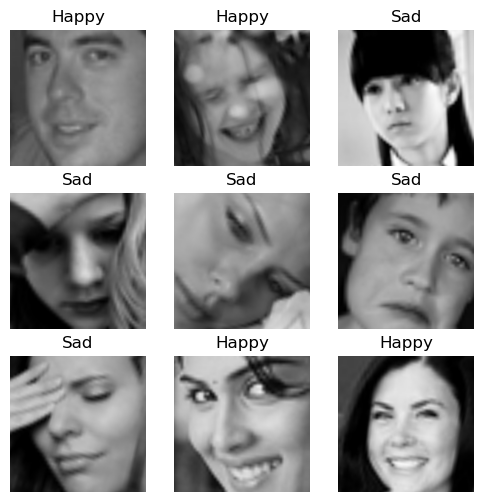

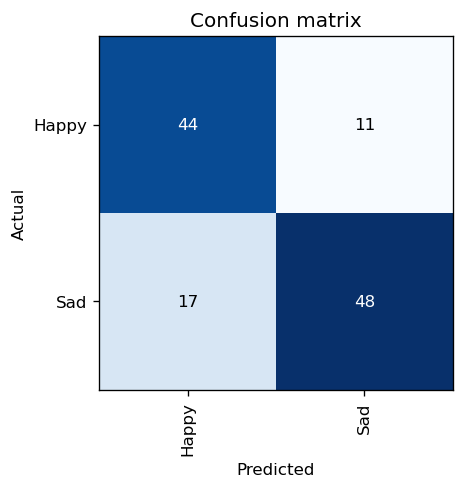

In [9]:
# Binary emotion classifier (fastai): Happy vs Sad 

from fastai.vision.all import *
import random
from collections import Counter

# -----------------------
# 1) Settings
# -----------------------
SEED = 42
MAX_PER_CLASS = 300
IMG_SIZE = 224
ARCH = resnet34
EPOCHS = 3
BS = 32
BASE_LR = 3e-3

random.seed(SEED)

# 2) Dataset path
path = Path("data")
assert path.exists(), f"Couldn't find folder: {path.resolve()}"

# 3) Build a capped file list: ONLY Happy + Sad, <=300 each
target_classes = {"Happy", "Sad"}   # folder names must match exactly

class_dirs = [p for p in path.iterdir() if p.is_dir() and p.name in target_classes]
found = {p.name for p in class_dirs}
missing = target_classes - found
assert not missing, f"Missing class folder(s): {missing}. Found: {sorted([p.name for p in path.iterdir() if p.is_dir()])}"

files = []
for cls_dir in sorted(class_dirs, key=lambda p: p.name):
    imgs = get_image_files(cls_dir)
    random.shuffle(imgs)
    files += imgs[:MAX_PER_CLASS]

print(f"Total images used: {len(files)}")
counts = Counter([parent_label(f) for f in files])
print("Images per class (capped at 300):")
for k in sorted(counts.keys()):
    print(f"  {k}: {counts[k]}")

# 4) DataLoaders 
batch_tfms = [
    *aug_transforms(
        size=IMG_SIZE,
        max_rotate=15,
        max_zoom=1.1,
        max_lighting=0.2,
        max_warp=0.1,
        p_affine=0.75,
        p_lighting=0.75,
    ),
    Normalize.from_stats(*imagenet_stats),
]

dls = ImageDataLoaders.from_path_func(
    path,
    files,
    label_func=parent_label,   # labels are folder names (Happy/Sad)
    valid_pct=0.2,
    seed=SEED,
    item_tfms=Resize(IMG_SIZE),
    batch_tfms=batch_tfms,
    bs=BS
)

print("\nClasses (vocab):", dls.vocab)

# Visual check
dls.show_batch(max_n=9, figsize=(6, 6))

# 5) Train
learn = vision_learner(dls, ARCH, metrics=[accuracy, error_rate])
learn.fine_tune(EPOCHS, base_lr=BASE_LR)

# 6) Evaluation 
val_loss, val_acc, val_err = learn.validate()
print(f"\nValidation results:")
print(f"  loss: {val_loss:.4f}")
print(f"  accuracy: {val_acc:.4f}")
print(f"  error_rate: {val_err:.4f}")

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(
    figsize=(4,4),
    dpi=120
)

